In [1]:
import requests
import json

#import googlemaps
from itertools import tee

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from scipy import stats

from matplotlib.colors import ListedColormap

In [38]:
travel_time=pd.read_csv('./r5r/output/ttm/2_ttm_pt_20230526.csv')
London = gpd.read_file('./data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
london_cwp = gpd.read_file('./data/MLSOA_Dec_2021_PWC_in_England_and_Wales_2022/MSOA_PopCentroids_london_2021.shp')

In [53]:
commute_time=pd.read_csv('final_data/travel_time_2011.csv')
commute_time_strike=pd.read_csv('final_data/travel_time_without_metro_2011.csv')

In [55]:
London=London.to_crs(epsg=4326)
London_MSOA=London.loc[:,['MSOA11CD', 'MSOA11NM']]
London['centre']=London.to_crs('+proj=cea').centroid.to_crs(epsg=4326)
London['centre_lat'] = London.centre.apply(lambda p: p.y)
London['centre_lon'] = London.centre.apply(lambda p: p.x)
London=London.loc[:,['MSOA11CD', 'MSOA11NM', 'centre']]
London=London.rename(columns={'centre':'geometry'})
London

In [54]:
commute_time=commute_time.rename(columns={'travel_time_p25':'commute_time_usual_p25',
                                         'travel_time_p50':'commute_time_usual_p50',
                                         'travel_time_p75':'commute_time_usual_p75'})
commute_time=commute_time.drop(['Unnamed: 0'], axis=1)
commute_time_strike=commute_time_strike.rename(columns={'travel_time_p25':'commute_time_strike_p25',
                                         'travel_time_p50':'commute_time_strike_p50',
                                         'travel_time_p75':'commute_time_strike_p75'})
commute_time_strike=commute_time_strike.drop(['Unnamed: 0'], axis=1)
commute_time_com = commute_time.merge(commute_time_strike, on=['Origin_MSOACD', 'Origin_MSOANM', 'Destination_MSOACD', 'Destination_MSOANM'])
commute_time_com

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual_p25,commute_time_usual_p50,commute_time_usual_p75,commute_time_strike_p25,commute_time_strike_p50,commute_time_strike_p75
0,E02000001,City of London 001,E02000001,City of London 001,0,0.0,0.0,0,0.0,0.0
1,E02000269,Ealing 032,E02000001,City of London 001,56,58.0,60.0,58,60.0,62.0
2,E02000213,Croydon 020,E02000001,City of London 001,49,51.0,53.0,53,55.0,57.0
3,E02000487,Havering 024,E02000001,City of London 001,60,63.0,67.0,66,69.0,73.0
4,E02000065,Bexley 001,E02000001,City of London 001,53,55.0,57.0,54,56.0,58.0
...,...,...,...,...,...,...,...,...,...,...
1015449,E02000952,Wandsworth 030,E02000364,Hackney 020,57,58.0,60.0,79,83.0,86.0
1015450,E02000275,Ealing 038,E02000364,Hackney 020,69,71.0,73.0,69,71.0,73.0
1015451,E02000978,Westminster 019,E02000364,Hackney 020,40,42.0,44.0,58,59.0,61.0
1015452,E02000436,Harrow 004,E02000364,Hackney 020,83,86.0,90.0,84,87.0,91.0


In [69]:
commute_time_com['commute_time_difference_p25']=commute_time_com['commute_time_strike_p25']-commute_time_com['commute_time_usual_p25']
commute_time_com['commute_time_difference_p50']=commute_time_com['commute_time_strike_p50']-commute_time_com['commute_time_usual_p50']
commute_time_com['commute_time_difference_p75']=commute_time_com['commute_time_strike_p75']-commute_time_com['commute_time_usual_p75']

commute_time_com.head()

,Origin_MSOACD,Origin_MSOANM,Destination_MSOACD,Destination_MSOANM,commute_time_usual_p25,commute_time_usual_p50,commute_time_usual_p75,commute_time_strike_p25,commute_time_strike_p50,commute_time_strike_p75,commute_time_difference_p25,commute_time_difference_p50,commute_time_difference_p75
0,E02000001,City of London 001,E02000001,City of London 001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,E02000269,Ealing 032,E02000001,City of London 001,56.000000,58.000000,60.000000,58.000000,60.000000,62.000000,2.000000,2.000000,2.000000
2,E02000213,Croydon 020,E02000001,City of London 001,49.000000,51.000000,53.000000,53.000000,55.000000,57.000000,4.000000,4.000000,4.000000
3,E02000487,Havering 024,E02000001,City of London 001,60.000000,63.000000,67.000000,66.000000,69.000000,73.000000,6.000000,6.000000,6.000000
4,E02000065,Bexley 001,E02000001,City of London 001,53.000000,55.000000,57.000000,54.000000,56.000000,58.000000,1.000000,1.000000,1.000000


In [70]:
pd.set_option('display.float_format', '{:.6f}'.format)
commute_time_com.describe()

,commute_time_usual_p25,commute_time_usual_p50,commute_time_usual_p75,commute_time_strike_p25,commute_time_strike_p50,commute_time_strike_p75,commute_time_difference_p25,commute_time_difference_p50,commute_time_difference_p75
count,1015454.000000,1011903.000000,1005434.000000,1015454.000000,985813.000000,953154.000000,1015454.000000,985746.000000,953036.000000
mean,65.977667,68.490122,70.801342,75.122785,77.327038,79.320547,9.145118,9.625543,10.069732
std,20.381922,20.826974,21.178647,23.031763,22.876388,22.669979,10.085383,10.319610,10.540743
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-21.000000,-22.000000,-23.000000
25%,52.000000,54.000000,56.000000,59.000000,61.000000,64.000000,0.000000,1.000000,1.000000
50%,66.000000,69.000000,71.000000,76.000000,78.000000,81.000000,6.000000,7.000000,7.000000
75%,80.000000,83.000000,86.000000,93.000000,95.000000,97.000000,15.000000,16.000000,16.000000
max,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,67.000000,69.000000,71.000000


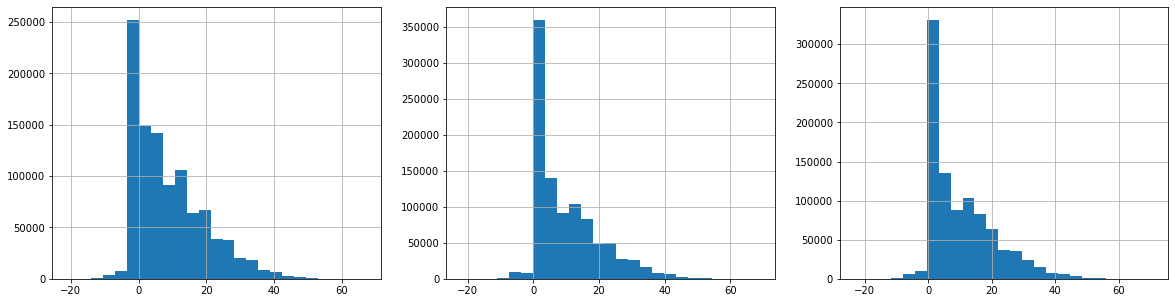

In [74]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=3)
commute_time_com['commute_time_difference_p25'].hist(bins=25, ax=axes[0])
commute_time_com['commute_time_difference_p50'].hist(bins=25, ax=axes[1])
commute_time_com['commute_time_difference_p75'].hist(bins=25, ax=axes[2])
plt.show()

In [91]:
commute_time_strike_mean=commute_time_com.groupby(by='Origin_MSOACD').mean()
commute_time_strike_mean=commute_time_strike_mean.loc[:,['commute_time_difference_p25', 'commute_time_difference_p50', 'commute_time_difference_p75']]
commute_time_strike_mean=commute_time_strike_mean.reset_index()
commute_time_strike_des_mean=commute_time_com.groupby(by='Destination_MSOACD').mean()
commute_time_strike_des_mean=commute_time_strike_des_mean.loc[:,['commute_time_difference_p25', 'commute_time_difference_p50', 'commute_time_difference_p75']]
commute_time_strike_des_mean=commute_time_strike_des_mean.reset_index()
commute_time_strike_mean.head()

,Origin_MSOACD,commute_time_difference_p25,commute_time_difference_p50,commute_time_difference_p75
0,E02000001,8.120493,8.776091,9.483840
1,E02000002,5.838747,5.299875,4.778226
2,E02000003,3.754263,4.061728,4.279020
3,E02000004,4.232558,4.150919,4.166432
4,E02000005,3.799376,4.030108,4.132203


<AxesSubplot:>

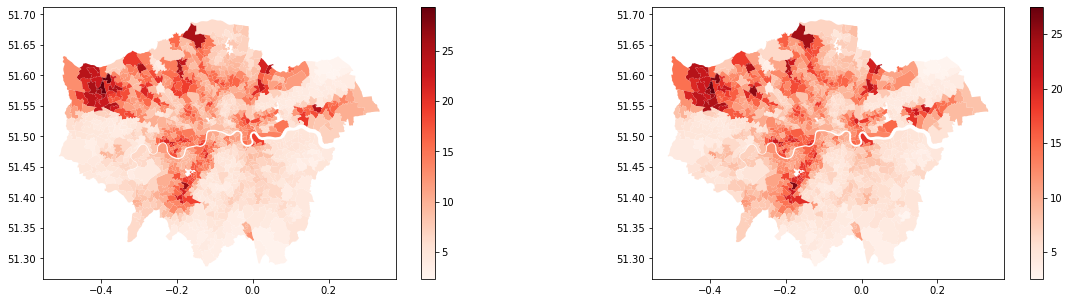

In [92]:
commute_time_strike_mean_geo=pd.merge(London, commute_time_strike_mean, left_on='MSOA11CD', right_on='Origin_MSOACD')
commute_time_strike_des_mean_geo=pd.merge(London, commute_time_strike_des_mean, left_on='MSOA11CD', right_on='Destination_MSOACD')
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=2)
#commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p25'], legend= True, cmap='Reds', ax=axes[0])
commute_time_strike_mean_geo.plot(column=commute_time_strike_mean_geo['commute_time_difference_p50'], legend= True, cmap='Reds', ax=axes[0])
commute_time_strike_mean_geo.plot(column=commute_time_strike_des_mean_geo['commute_time_difference_p50'], legend= True, cmap='Reds', ax=axes[1])